In [71]:
import pandas as pd
from sklearn.utils import shuffle
from simulations import build_block_model
#from deicode.utils import build_block_model
from deicode.preprocessing import rclr
from deicode.optspace import OptSpace
import seaborn as sns
import pandas as pd
import numpy as np
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

def plot_pcoa(samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, 1],
           samples.loc[idx, 0], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

%matplotlib inline

Here as a negative control we will compare RPCA output from a clear block model of rank 2 (positive control) and a negative control of random counts with the same mean seq. depth.

In [167]:

depth=2.5e3
overlap_=0
rank_=2
#run model with fit variables and new variants
_,X_signal=build_block_model(rank_,  depth/60, depth/60, 
                             depth, depth
                             ,200,1000,overlap=overlap_
                             ,mapping_on=False)
X_signal=pd.DataFrame(X_signal,
                      index=['OTU_'+str(x)
                                for x in range(X_signal.shape[0])],
                      columns=['sample_'+str(x) 
                               for x in range(X_signal.shape[1])])

#run model with fit variables and new variants
X_random=np.random.randint(0,np.mean(X_signal.values)*2.3,(1000,200))
X_random=pd.DataFrame(X_random,
                      index=['OTU_'+str(x)
                                for x in range(X_random.shape[0])],
                      columns=['sample_'+str(x) 
                               for x in range(X_random.shape[1])])
X_random.index = shuffle(X_random).index
X_random.columns = shuffle(X_random.T).index
X_random=X_random.T
X_random.sort_index(inplace=True)
X_random=X_random.T
X_random.sort_index(inplace=True)


#meta on cluster
meta = np.array([1]*int(X_signal.shape[1]/2)+[2]*int(X_signal.shape[1]/2)).T
meta = pd.DataFrame(meta,index=X_signal.columns,columns=['group'])

print('X_random mean %.2f seq/sample'%X_random.sum(axis=0).mean())
print('X_signal mean %.2f seq/sample'%X_signal.sum(axis=0).mean())


X_random mean 3993.71 seq/sample
X_signal mean 4114.79 seq/sample


In [168]:
opt_random = OptSpace().fit(X_random_rclr)
opt_random.explained_variance_ratio

[0.50947550249018814, 0.49052449750981181]

In [169]:
opt_sig = OptSpace().fit(X_signal.T)
opt_sig.explained_variance_ratio

[0.83536892709105659, 0.16463107290894344]

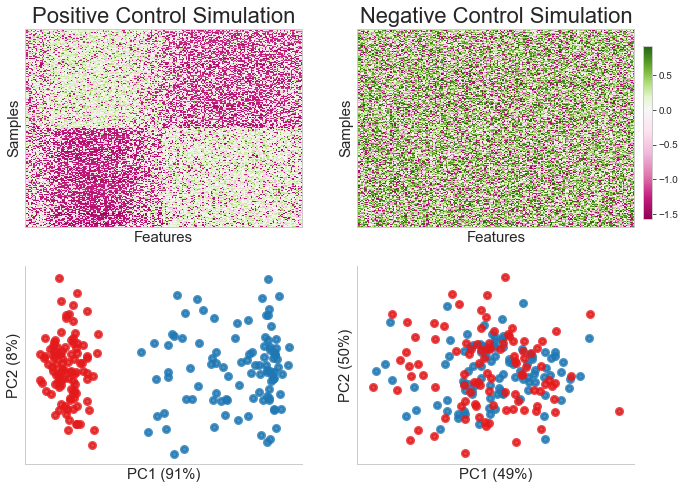

In [183]:
#RPCA on random
X_random_rclr = rclr().fit_transform(X_random.T)
opt_noise = OptSpace().fit(X_random_rclr)
U_random = pd.DataFrame(opt_noise.sample_weights,index=X_random.columns)
#RPCA on very clear signal
X_signal_rclr = rclr().fit_transform(X_signal.T)
opt_sig = OptSpace().fit(X_signal_rclr)
U_signal = pd.DataFrame(opt_sig.sample_weights,index=X_signal.columns)

#show the results
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,8))

ax1.imshow(clr(X_signal+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
ax1.set_title('Positive Control Simulation',fontsize=22)
cbim = ax2.imshow(clr(X_random+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
ax2.set_title('Negative Control Simulation',fontsize=22)
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylabel('Samples',fontsize=15)
ax1.set_ylabel('Samples',fontsize=15)
ax2.set_xlabel('Features',fontsize=15)
ax1.set_xlabel('Features',fontsize=15)
fig.subplots_adjust(right=0.83)
cbar_ax = fig.add_axes([0.84, 0.55, 0.01, 0.3])
fig.colorbar(cbim, cax=cbar_ax, fraction=0.036)
cbar_ax.tick_params(labelsize=10) 
_ = plot_pcoa(U_signal, meta, ax3, 'group')
_ = plot_pcoa(U_random, meta, ax4, 'group')

ax3.set_xlabel('PC1 ('+str(int(opt_sig.explained_variance_ratio[0]*100))+'%)',fontsize=15)
ax3.set_ylabel('PC2 ('+str(int(opt_sig.explained_variance_ratio[1]*100))+'%)',fontsize=15)

ax4.set_xlabel('PC1 ('+str(int(opt_noise.explained_variance_ratio[0]*100))+'%)',fontsize=15)
ax4.set_ylabel('PC2 ('+str(int(opt_noise.explained_variance_ratio[1]*100))+'%)',fontsize=15)

fig.savefig('figures/figureS4.png',dpi=300, 
            bbox_inches='tight',facecolor='white')
plt.show()


In [184]:
#PCoA and PERMANOVA
from scipy.spatial import distance
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [185]:
pres = {}
pnoise = permanova(DistanceMatrix(distance.cdist(U_random,U_random)),meta['group'])
pres[('Negative Control','F-statistic')] = [pnoise['test statistic']]
pres[('Negative Control','p-value')] = [pnoise['p-value']]
psignal = permanova(DistanceMatrix(distance.cdist(U_signal,U_signal)),meta['group'])
pres[('Positive Control','F-statistic')] = [psignal['test statistic']]
pres[('Positive Control','p-value')] = [psignal['p-value']]
pres = pd.DataFrame(pres,index=['PRMANOVA'])
pres


Negative Control         Positive Control        
              F-statistic p-value      F-statistic p-value
PRMANOVA         0.650725   0.512       158.543171   0.001

In [186]:
knnres = {}
for U_,T_,Tit_ in zip([U_random,U_signal],[X_random,X_signal],['Negative Control','Positive Control']):
    pcoa_tmp = pcoa(DistanceMatrix(distance.cdist(U_,U_))).samples
    pcoa_tmp.index = T_.T.index
    # split
    X_train, X_test, y_train, y_test = train_test_split(pcoa_tmp, meta['group'].ravel(), 
                                                        test_size=.2, 
                                                        stratify=meta['group'].ravel(), 
                                                        random_state=42)
    knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    acc_ = accuracy_score(y_test,knn.predict(X_test).astype(int))
    knnres[(Tit_,'Accuracy')] = [acc_]
knnres = pd.DataFrame(knnres,index=['KNN-Classifier'])
knnres


,Negative Control,Positive Control
,Accuracy,Accuracy
KNN-Classifier,0.65,1.0
